## **Построение модели расчета количества визитов застрахованных работников компании по ДМС в медицинские учреждения в 2023 году**

### **Формулировка задачи:**

Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год. Требуется на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год.

Доступны 2 выборки:

- train - выборка для обучения и валидации , 50 тыс. застрахованных с проставленными значениями target.
- holdout - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения target скрыты.

**Метрика оценки качества:** Для оценки качества модели будет применяться метрика MSE.


### **Описание данных:**

- *Insured_PIN* - уникальный ид застрахованного лица
- *Insured_Network* - Идентификатор сети клиник доступной для застрахованного.
>*Network - 1* - клиники с наивысшим уровнем сервиса, *Network - 8* - клиники с самым базовым уровнем сервиса.
- *Nationality* - национальность застрахованного.
- *Gender* - пол застрахованного
- *Relation* - в качестве кого застраховано данное лицо.
>*self* - работник организации, которая оформляет страховку, *child* - ребенок застрахованного и т.д.
- *DoB* - дата рождения застрахованного
- *Diagnoses* - все диагнозы застрахованного за 2022 год
- *HasChronicDisease* - флаг хронического пациента
- *Exposition_22* - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- *number_of_visits_22* - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- *number_of_services_22* - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- *Exposition_23* - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- *number_of_visits_23* - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**

### **Что полуаем в результате:**
- Файл .csv с предсказаниями на выборке holdout с указанием ид застрахованного и предсказанием модели
- Список использованных признаков с указанием их значимости

### **План работы:**
1. Загрузка и первичный анализ данных.
2. Анализ данных (EDA)
3. Предварительная подготовка данных:
 - Предобработка данных
 - Cоздние полезных признаков для обучения модели.
4. Подготовка общего датасета для дальнейшего исследования и обучения.
5. Обучение модели.
6. Проверка модели на тестовой выборке.
7. Выводы.

In [ ]:
#проект запускаю в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost >> None
    !"{sys.executable}" -m pip install phik >> None

    print('Environment: Google Colab')

# импорт моделей
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression


import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix

Environment: Google Colab


In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump
import math
import time
import re
import datetime

# предварительная обработка
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# кроссвалидация
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor

# метрики
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error,  mean_squared_error

# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 123456

In [ ]:
#если данные храняться на googledisk, подключаем его
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. **Загрузка и первичный анализ данных**

In [ ]:
try:
    #если данные храняться на googledisk
    data_train = pd.read_excel('/content/drive/MyDrive/TEST/Медицина/ML_train.xlsx')
    data_holdout = pd.read_excel('/content/drive/MyDrive/TEST/Медицина/ML_holdout.xlsx')
except:
    # Загрузка Excel файла
    data_train = pd.read_excel('/content/drive/MyDrive/TEST/Медицина/ML_train.xlsx')
    data_holdout = pd.read_excel('/content/drive/MyDrive/TEST/Медицина/ML_holdout.xlsx')

In [ ]:
# функция первичного знакомства с данными
def express_info(data, name):
    print(f'Информация о {name}:')
    data.info()
    display(data.head(5))
    print()

In [ ]:
express_info(data_train, 'обучающей выборке')

Информация о обучающей выборке:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    50000

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,NaN,0,365,0,0,365,0


In [ ]:
express_info(data_holdout, 'данных для итоговой выборке')

Информация о данных для итоговой выборке:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int64         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int64         
 8   Exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365


In [ ]:
data_train[data_train['Insured_PIN']==1354276]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23


In [ ]:
data_holdout[data_holdout['Insured_PIN']==22210474]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365


In [ ]:
#напишем функцию для исследования данных
def research(data, name, figsize1, figsize2, silent):
    # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {data.shape}') #numeric_data
    print(f'Количество явных дубликатов: {data.duplicated().sum()}') #numeric_data
    print(f'Наличие пропусков:           {data.isna().sum().sum()}') #numeric_data
    print('Пропущенные данные (в процентном соотношении):')

    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(data.isna().mean()*100).sort_values(ascending=False))#.head(15) #numeric_data

    if not silent:
        print(f'\nПроверка структуры {name}:')
        Y = 0.96
        F = 12/Y
        numeric_data.hist(linewidth=2, histtype='step', figsize=figsize1)
        plt.suptitle(f'Гистограмма распределения {name}', y=Y, fontsize=F)
        plt.show()

    if not silent:
        plt.figure(figsize=figsize2)#(40, 20)
        matrix = np.triu(numeric_data.corr())
        heatmap = sns.heatmap(numeric_data.corr(), annot=True, fmt='.2g',
                      mask=matrix, square=True,
                      cmap='GnBu',  cbar=False,
                      xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)
        plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.90, fontsize=13)
        plt.show()
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        display(numeric_data.describe())

    #if not silent:
    display(data.head(5))

Размер данных:      (50000, 13)
Количество явных дубликатов: 0
Наличие пропусков:           8775
Пропущенные данные (в процентном соотношении):
Diagnoses                18.0
Insured_PIN               0.0
Insured_Network           0.0
Nationality               0.0
Gender                    0.0
Relation                  0.0
DoB                       0.0
HasChronicDisease         0.0
Exposition_22             0.0
number_of_visits_22       0.0
number_of_services_22     0.0
Exposition_23             0.0
number_of_visits_23       0.0
dtype: float64

Проверка структуры данных обучающей выборки:


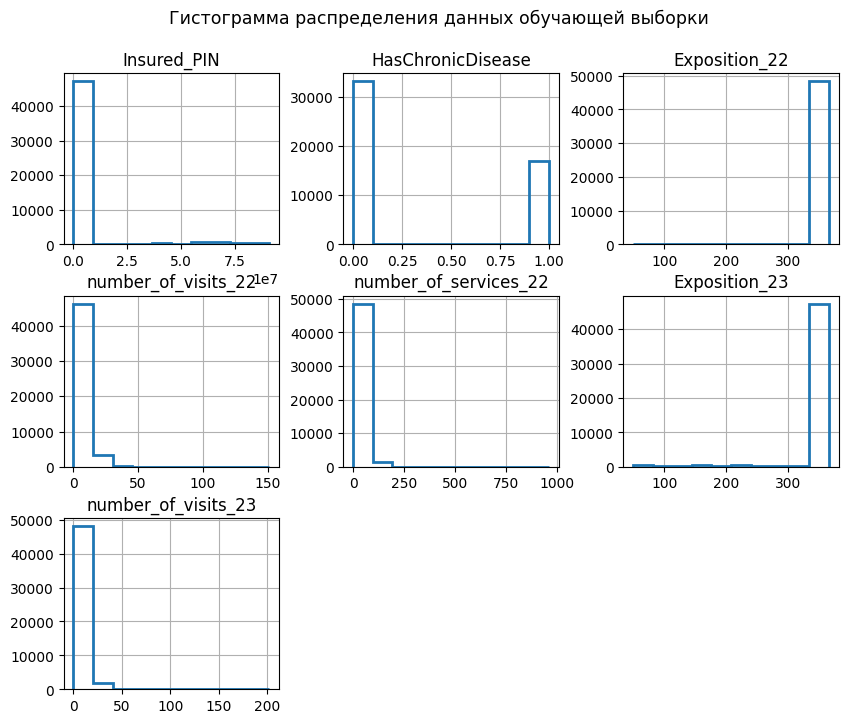

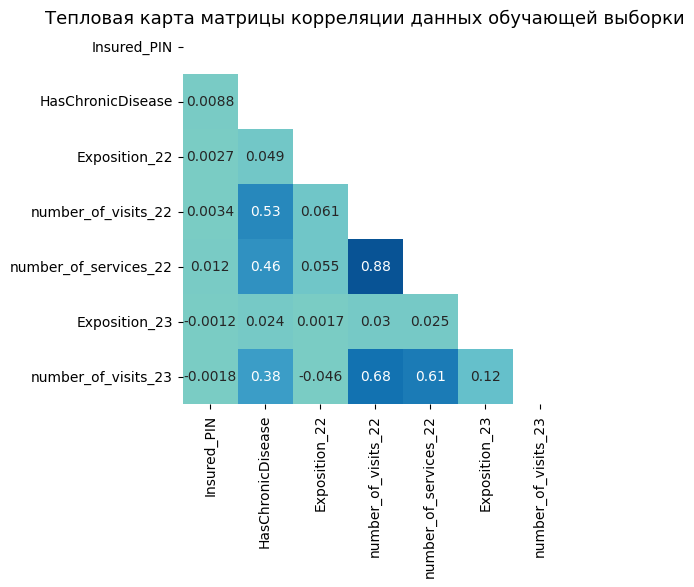

,Insured_PIN,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000
mean,5105306.529,0.338,358.899,5.740,22.477,355.588,5.899
std,14439779.732,0.473,35.562,6.593,29.714,43.779,6.857
min,7491.000,0.000,50.000,0.000,0.000,50.000,0.000
25%,1394019.750,0.000,365.000,1.000,3.000,365.000,1.000
50%,1456638.000,0.000,365.000,4.000,13.000,365.000,4.000
75%,1560591.000,1.000,365.000,8.000,31.000,365.000,8.000
max,91005334.000,1.000,365.000,151.000,962.000,365.000,202.000


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,NaN,0,365,0,0,365,0


In [ ]:
research(data_train, 'данных обучающей выборки', figsize1=(10, 8), figsize2=(8, 5), silent=False)

Размер данных:      (10000, 12)
Количество явных дубликатов: 0
Наличие пропусков:           1726
Пропущенные данные (в процентном соотношении):
Diagnoses               17.000
Insured_PIN              0.000
Insured_Network          0.000
Nationality              0.000
Gender                   0.000
Relation                 0.000
DoB                      0.000
HasChronicDisease        0.000
Exposition_22            0.000
number_of_visits_22      0.000
number_of_services_22    0.000
Exposition_23            0.000
dtype: float64

Проверка структуры данных итоговой выборки:


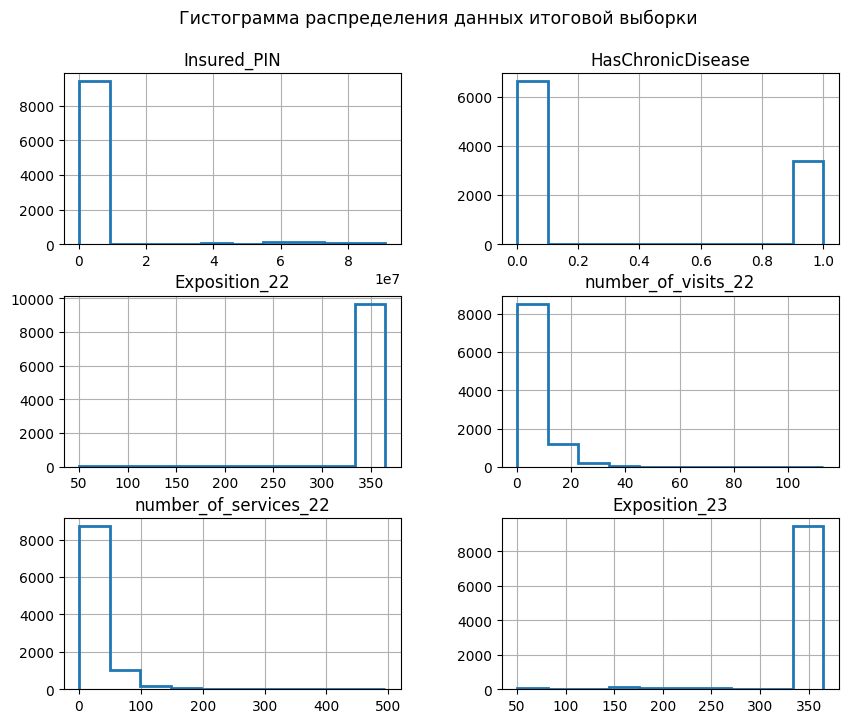

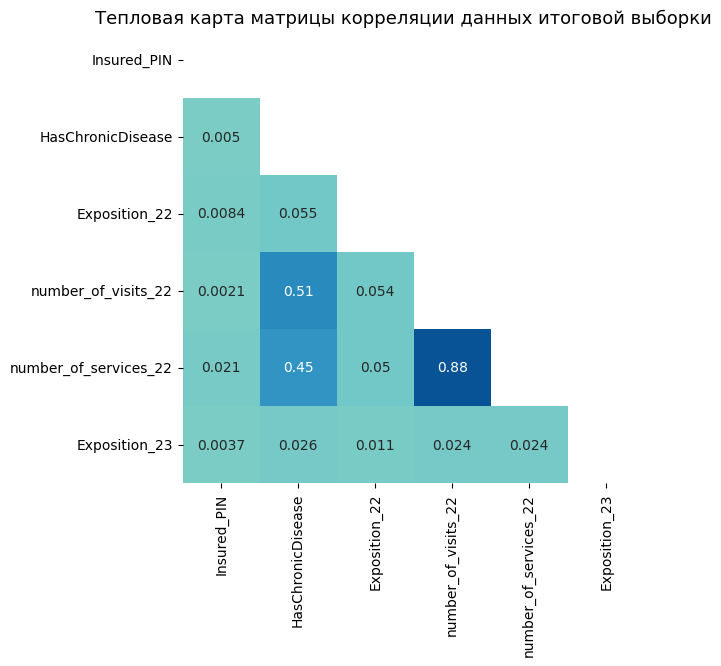

,Insured_PIN,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5321900.031,0.338,359.426,5.824,22.991,355.039
std,14879404.911,0.473,33.757,6.789,30.820,45.308
min,63665.000,0.000,50.000,0.000,0.000,50.000
25%,1394638.000,0.000,365.000,1.000,3.000,365.000
50%,1457448.000,0.000,365.000,4.000,13.000,365.000
75%,1622644.750,1.000,365.000,8.000,31.000,365.000
max,91051569.000,1.000,365.000,113.000,495.000,365.000


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365


In [ ]:
research(data_holdout, 'данных итоговой выборки', figsize1=(10, 8), figsize2=(8, 6), silent=False)

In [ ]:
#Проверим, на всякий случай на пропуски напрямую (так как, если маленькое число- в процентном соотношении можно не увидеть)
print('Обучающая выборка:', data_train.isna().sum())
display(data_train[data_train['DoB'].isna()])

print('Тестовая выборка:', data_holdout.isna().sum())

Обучающая выборка: Insured_PIN                 0
Insured_Network             0
Nationality                 0
Gender                      0
Relation                    0
DoB                         1
Diagnoses                8774
HasChronicDisease           0
Exposition_22               0
number_of_visits_22         0
number_of_services_22       0
Exposition_23               0
number_of_visits_23         0
dtype: int64


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
23626,1451433,Network-2,Saudi,Male,Self,NaT,H93.1;A09.9;R10;N39.0;M79;E78.5;N77.1;M23;E11....,1,365,15,62,365,14


Тестовая выборка: Insured_PIN                 0
Insured_Network             0
Nationality                 0
Gender                      0
Relation                    0
DoB                         0
Diagnoses                1726
HasChronicDisease           0
Exposition_22               0
number_of_visits_22         0
number_of_services_22       0
Exposition_23               0
dtype: int64


#### Выводы:
- явных дубликатов в данных нет.
- Пропуски во всех датасетах в основном касательно диагнозов. В процентном соотношении приблизительно одинаково 17% и 18%. Поставим загулшки на них. Из данных видно, что в основном это связано, с тем, что пациент не обращался в клинику.
- Также есть 1 пропуск по возрасту на обучающей выборке - мы не можем предполагать истинный возраст пациента - удалим строку (так как у нас достаточно данных, удаление 1 значения не повлияет на результат).
- Из первичного анализа тепловой карты видна - корреляция данных количества посещений пациента и количество оказанных услуг - что вполне логично. Это важно - для целевого признака.
- Средние данные количества визитов в обоих выборках на уровне 6.7, скдя по тренировочной выборнке наблюдаеттся тенденция к увеличению количества визитов в 2023 - на это будем обращать внимание при построении модели.
- далее проверим на аномальные значения и тп;

## **2. Анализ данных (EDA)**
 - Работа с аномалиями, пропусками и дубликатами.
 - Анализ признаков.

In [ ]:
#Напишем функцию для проверки данных на аномалии
def feed_size(data, state, name_state): #, x_lim0, x_lim
    print(f'Статистические данные о распределении значений {name_state} ({state}):')
    display(data[f'{state}'].describe())

    plt.subplots(figsize=(15, 1))
    #plt.xlim([x_lim0, x_lim])
    plt.title(f'Диаграмма рассеяния {name_state} ({state})')
    sns.boxplot(x=data[state], palette='pastel')
    plt.show()
    print()

    plt.figure(figsize=(15, 2))
    #sns.kdeplot(data[f'{state}'], fill=True, label=f'{state} {name_state}', alpha=0.6, shade=True)
    sns.histplot(data[f'{state}'], color="seagreen", label=f'{name_state}', alpha=0.7, kde=True)
    #plt.xlim([x_lim0, x_lim])
    plt.xlabel(f'{state}')
    plt.ylabel(f'Распределение вероятности \nнепрерывной величины')
    plt.legend(loc='upper right')
    plt.title(f'Гистограмма распределения {name_state} ({state})', fontsize=12)
    plt.show()

### Исследуем целевой признак `'number_of_visits_23'` и `'number_of_visits_22'`
#### Обучающая выборка

Статистические данные о распределении значений данных обучающей выборки 2022 год (number_of_visits_22):


count   50000.000
mean        5.740
std         6.593
min         0.000
25%         1.000
50%         4.000
75%         8.000
max       151.000
Name: number_of_visits_22, dtype: float64

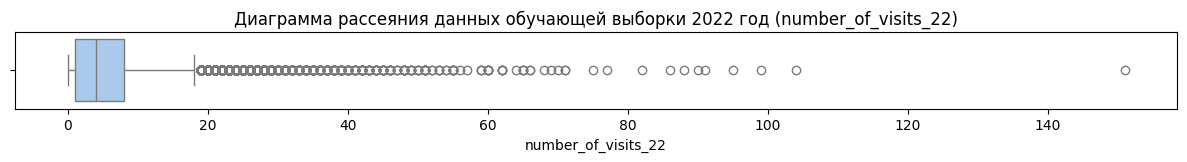

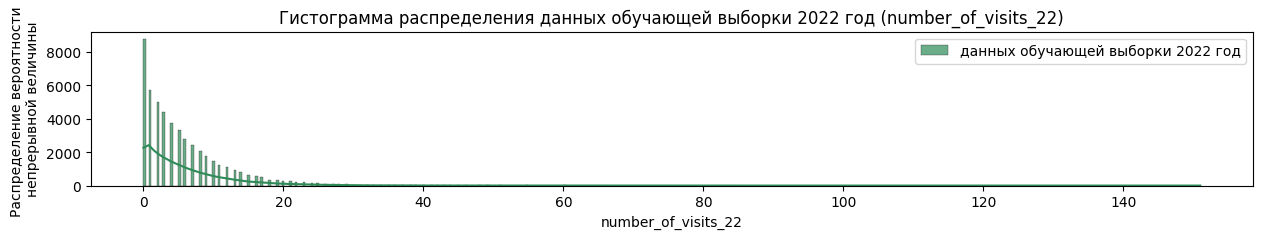

Статистические данные о распределении значений данных обучающей выборки 2023 год (number_of_visits_23):


count   50000.000
mean        5.899
std         6.857
min         0.000
25%         1.000
50%         4.000
75%         8.000
max       202.000
Name: number_of_visits_23, dtype: float64

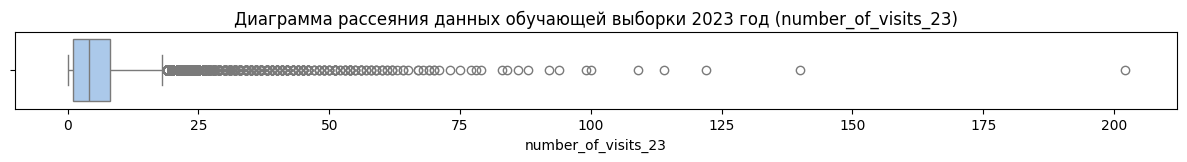

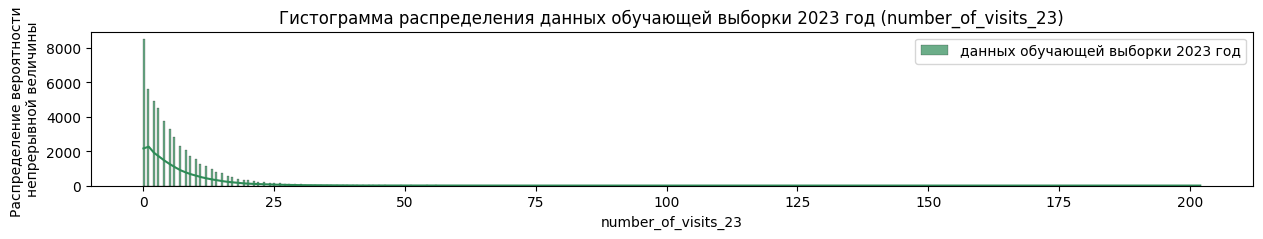

In [ ]:
feed_size(data_train, 'number_of_visits_22', 'данных обучающей выборки 2022 год') #, 150
feed_size(data_train, 'number_of_visits_23', 'данных обучающей выборки 2023 год')

In [ ]:
data_train[data_train['number_of_visits_22'] > 100]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
17292,1419016,Network-2,Saudi,Male,Self,1946-05-31,R52.9;K29.1;E13.52;M54.5;E10.42;I87.2;I95.9;A4...,1,365,151,962,365,202
19620,1431423,Network-2,Saudi,Male,Self,1978-04-24,G62.9;E27.3;E11;E03;H16.0;M79.66;R06.0;M25.5;J...,0,365,104,754,365,140


In [ ]:
data_train[data_train['number_of_visits_23'] > 100]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
4275,1354538,Network-2,Saudi,Male,Self,1987-09-11,K29;J02;R05;A04.9;A08.4;R50;R51;J03;J00;R10;K2...,1,365,55,97,365,122
7247,1369400,Network-2,Saudi,Female,Self,1947-05-21,R11;J06;N18;R06.0;N18.5;R10.4;Z49.1;I52;R07.4;...,0,365,10,104,365,114
8464,1375432,Network-2,Saudi,Female,Self,1966-10-15,E11;B07;M17.0;E55;E78;K21;A09.9;E78.5;M17,0,365,16,72,365,109
17292,1419016,Network-2,Saudi,Male,Self,1946-05-31,R52.9;K29.1;E13.52;M54.5;E10.42;I87.2;I95.9;A4...,1,365,151,962,365,202
19620,1431423,Network-2,Saudi,Male,Self,1978-04-24,G62.9;E27.3;E11;E03;H16.0;M79.66;R06.0;M25.5;J...,0,365,104,754,365,140


#### Проверочная выборка

Статистические данные о распределении значений данных проверочной выборки 2022 год (number_of_visits_22):


count   10000.000
mean        5.824
std         6.789
min         0.000
25%         1.000
50%         4.000
75%         8.000
max       113.000
Name: number_of_visits_22, dtype: float64

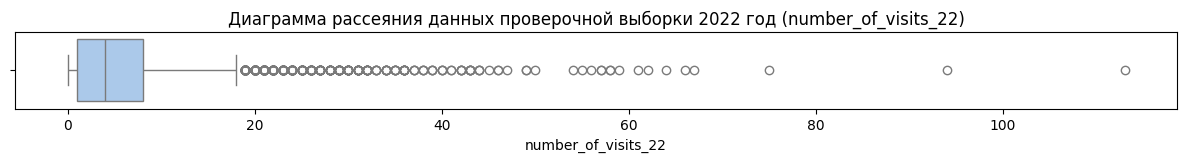

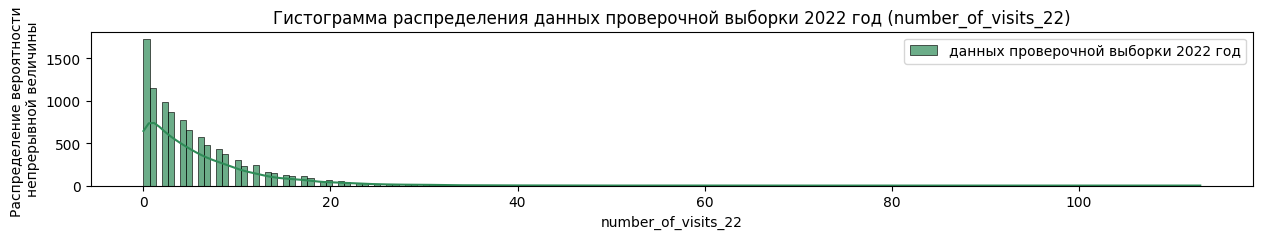

In [ ]:
feed_size(data_holdout, 'number_of_visits_22', 'данных проверочной выборки 2022 год')

In [ ]:
print ('Количество пациентов с нулевыми посещениями на обучающей выборке:',\
       len(data_train[data_train['number_of_visits_22']==0])) #.count()
print ('Количество пациентов с нулевыми посещениями на обучающей выборке \n\
в процентном соотношении:', len(data_train[data_train['number_of_visits_22']==0])/len(data_train)*100)

Количество пациентов с нулевыми посещениями на обучающей выборке: 8774
Количество пациентов с нулевыми посещениями на обучающей выборке 
в процентном соотношении: 17.548


In [ ]:
print ('Количество пациентов с нулевыми посещениями на проверочной выборке:',\
       len(data_holdout[data_holdout['number_of_visits_22']==0]))
print ('Количество пациентов с нулевыми посещениями на проверочной выборке \n\
в процентном соотношении:', len(data_holdout[data_holdout['number_of_visits_22']==0])/len(data_holdout)*100)

Количество пациентов с нулевыми посещениями на проверочной выборке: 1726
Количество пациентов с нулевыми посещениями на проверочной выборке 
в процентном соотношении: 17.26


#### Исследуем признак `number_of_services_22`

Статистические данные о распределении значений данных обучающей выборки (number_of_services_22):


count   50000.000
mean       22.477
std        29.714
min         0.000
25%         3.000
50%        13.000
75%        31.000
max       962.000
Name: number_of_services_22, dtype: float64

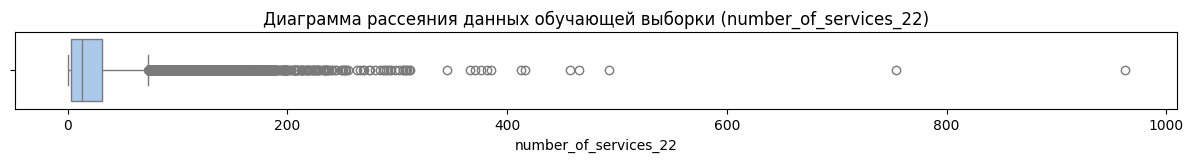

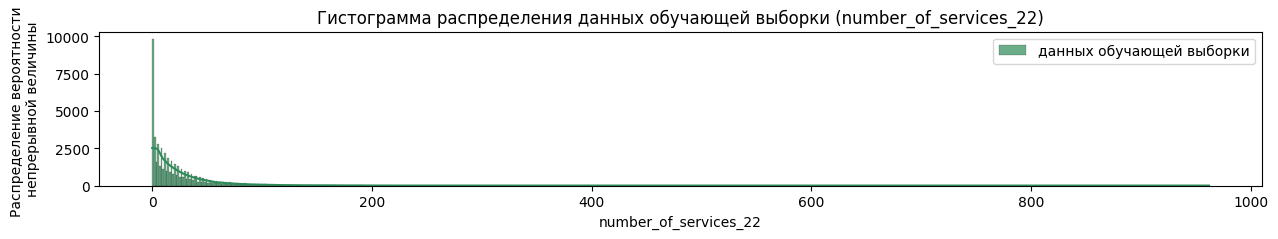


Статистические данные о распределении значений данных финальной выборки (number_of_services_22):


count   10000.000
mean       22.991
std        30.820
min         0.000
25%         3.000
50%        13.000
75%        31.000
max       495.000
Name: number_of_services_22, dtype: float64

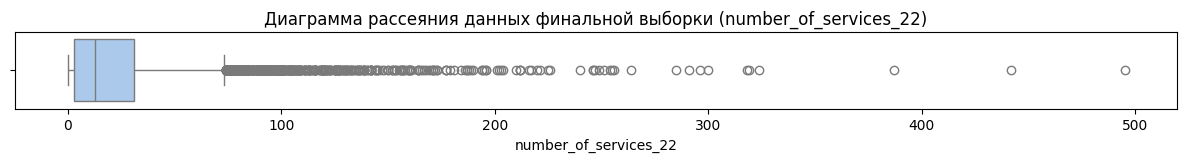

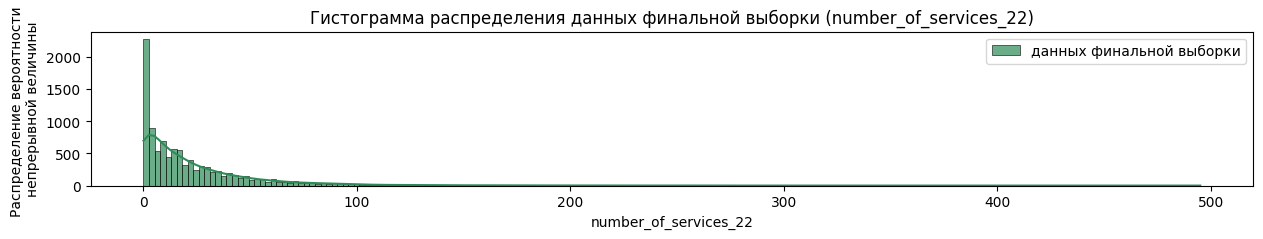

In [ ]:
feed_size(data_train, 'number_of_services_22', 'данных обучающей выборки')
print()
feed_size(data_holdout, 'number_of_services_22', 'данных финальной выборки')

#### Функция исследования количества пациентов по посещению `number_of_visits_22` относительно возраста

In [ ]:
#Функция исследования количества пациентов по посещению number_of_visits_22 относительно возраста
def graph_visits(data, name_y, name_title, name_count):
    plt.figure(figsize=(18, 5))
    sns.lineplot(data=data, x=data.index, y=name_y)
    plt.xlabel('Дата')
    plt.ylabel(f'Посещения, {name_count}')
    plt.title(f'Посещения {name_title}')
    plt.grid(True)
    plt.show()

def age_visitors(data, check_col, number_visits):
    data_age = data.pivot_table(
    index=[check_col, 'Insured_PIN'], values=[number_visits],
    aggfunc=sum).sort_values(by=number_visits, ascending=False).reset_index()
    data_age.set_index('DoB', inplace=True)
    display(data_age.sample(3))
    return data_age

In [ ]:
age_visitors22 = age_visitors(data_train, 'DoB', 'number_of_visits_22')
#graph_visits(age_visitors22, 'number_of_visits_22', 'общее количество в 2022 году(распределение по возрасту)', 'шт')

,Insured_PIN,number_of_visits_22
DoB,,
1991-03-02,1544274,3
2020-12-17,3248190,10
1960-12-19,1366210,0


Планирую переводить дату в возраст - как переведу - проверю на реальность данных

### **Исследуем категорийные признаки**

In [ ]:
#Напишем функцию
def plot_pie(data, title):
  graph = data.value_counts()\
  .plot.pie(legend=True,labeldistance=1.1, autopct='%1.2f%%', figsize=(5,5))
  plt.title(title)
  plt.show()
  print()

#### Обучающая выборка

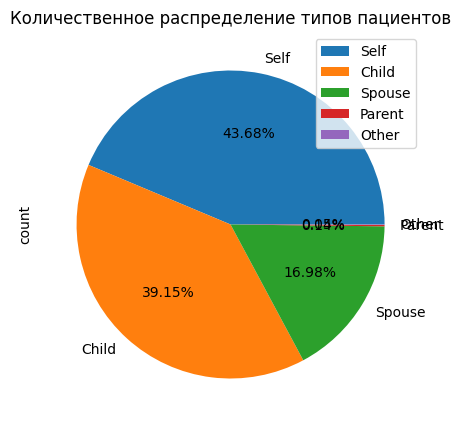

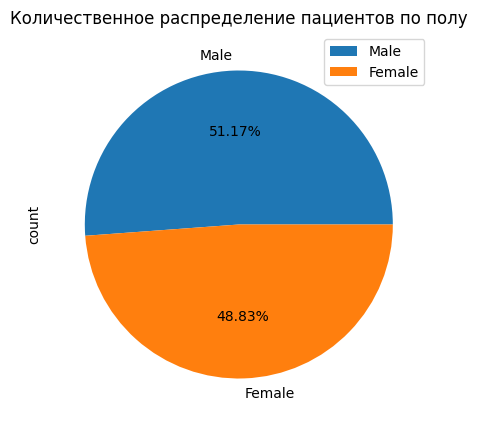

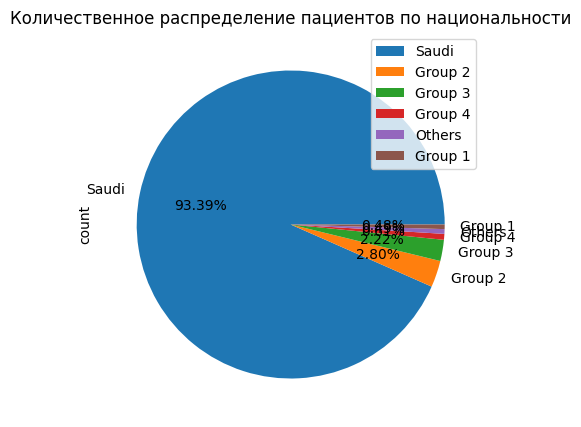

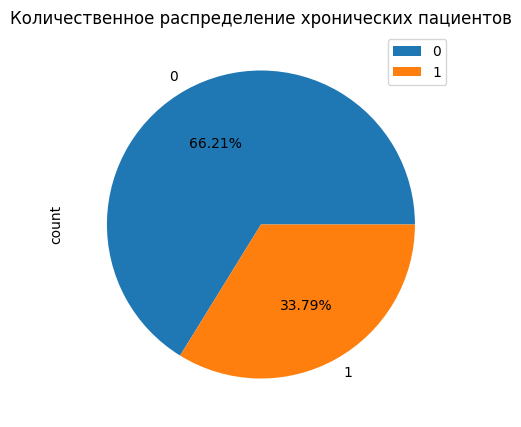

In [ ]:
# Проанализируем 'Relation'
plot_pie(data_train['Relation'], 'Количественное распределение типов пациентов')
#data_train['Relation'].value_counts() #.unique()
#data_train[data_train['Relation']== 'Other'].sample(5)

# Проанализируем `Gender`
plot_pie(data_train['Gender'], 'Количественное распределение пациентов по полу')

# Проанализируем `Nationality`
plot_pie(data_train['Nationality'], 'Количественное распределение пациентов по национальности')

# Проанализируем `HasChronicDisease`
plot_pie(data_train['HasChronicDisease'], 'Количественное распределение хронических пациентов')
# 1 - есть хроническое заболевание, 0 - нет

#### Проверочная выборка

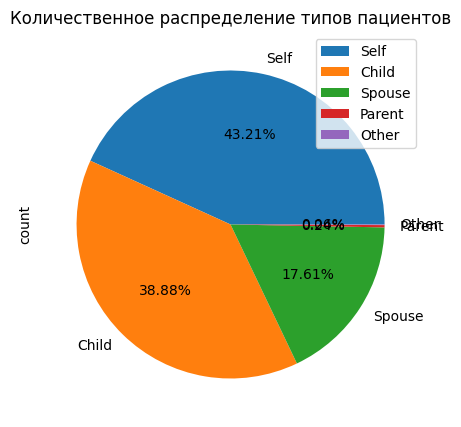

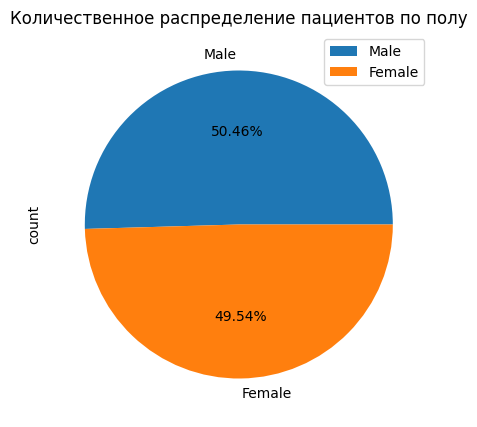

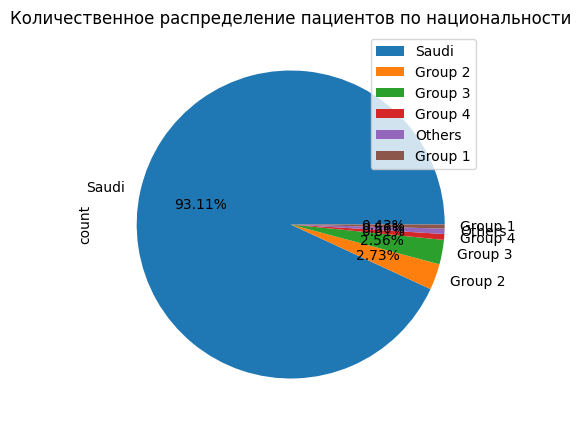

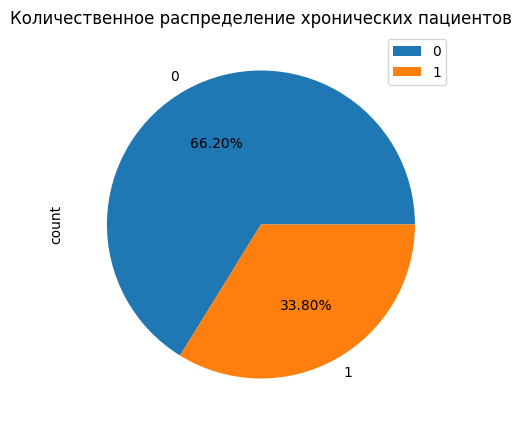

In [ ]:
# Проанализируем 'Relation'
plot_pie(data_holdout['Relation'], 'Количественное распределение типов пациентов')
#data_train['Relation'].value_counts() #.unique()
#data_train[data_train['Relation']== 'Other'].sample(5)

# Проанализируем `Gender`
plot_pie(data_holdout['Gender'], 'Количественное распределение пациентов по полу')

# Проанализируем `Nationality`
plot_pie(data_holdout['Nationality'], 'Количественное распределение пациентов по национальности')

# Проанализируем `HasChronicDisease`
plot_pie(data_holdout['HasChronicDisease'], 'Количественное распределение хронических пациентов')
# 1 - есть хроническое заболевание, 0 - нет

#### Вывод:
- есть какая-то аномалия на количестве посещений в 150 шт в 2022 году и 202 в 2023 7 что в принципе соответсвует правде, так как у пациента явно много диагнозов. Несмотря на то. что это не выброс, а реальная информация - считаю, что следует удалить эти данные, так как эт о единичный сучай, что может исказить данные при посмтроении модели (к тому же в тестовой выборке, максимальная цифра - 113)
- количество пациентов с 0 посещениями практически соответствует количеству пропущенных значений в диагнозе. что говорит о корректности данных.
- распределение количественных признаков соответствует нормальному.

- анализ качественных признаков показал:
  - основная часть пациентов - это сам работник(43,7%) и его дети (39%), значительно меньше - супруги (16%), и лишь малая часть другие родственники.
  - приблизительно равное количество - мужчин/женщин
  - 66% - хронических пациентов (что печаньно, общее состояние здоровье не слишком хорошо)
  > на проверочной выборке - цифры похожи

- также планирую переводить даты рождения в возраст - проверю данные на нормальность и аномальность.

## **3. Предварительная подготовка данных:**
 - Предобработка данных
 - Cоздние полезных признаков для обучения модели.

### Предобработка данных:
- поставим заглушки на пропущенные значения
- удалим пропуски в `'DoB'`
- удалим пациента - с очень большими показателями посещений
- создадим фичи - посчитаем возраст пациентов

In [ ]:
# функция преобразования датасета
def clean_data(data):
    # Удалим пропуски в data_train['DoB']
    data = data[~data['DoB'].isna()]
    #data_train = data_train.dropna(subset='DoB'])
    display('Проверим наличие пропусков в столбце DoB:', data[data['DoB'].isna()])

    # Заменим пропуски в таблице data на 'unknown' с помощью функции fillna()
    data.fillna('unknown', inplace=True)
    #data['Diagnoses'] = data['Diagnoses'].str.split(';') #.tolist()
    #tokens = data_train['Diagnoses'].str.split(';').explode()

    # Удалим пациента с большим количеством посешщений в 2022 году
    data = data[data['number_of_visits_22'] <= 150]
    display('Проверим наличие удалили ли данные о пациенте с посещениями в 22 году более 150 шт:', data[data['number_of_visits_22'] > 150])

    # Cоздадим фичи - посчитаем возраст пациентов
    data['DoB'] = pd.to_datetime(data['DoB'])
    data['Age_22'] = (pd.to_datetime('31-12-2022') - data['DoB']).dt.days // 365

    # удалим столбец за 'DoB' ненадобностью
    data = data.drop('DoB', axis=1)

    return data

In [ ]:
def calculate_age(dob):
    dob_string = dob.strftime('%Y-%m-%d')
    today = datetime.datetime(2022, 12, 31)
    birthdate = datetime.datetime.strptime(dob_string, '%Y-%m-%d')
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month,birthdate.day))
    return age

#### Преобразуем тренировочный датасет

In [ ]:
data_train1 = clean_data(data_train)
print('Предобработанный датасет:')
display(data_train1.head())

'Проверим наличие пропусков в столбце DoB:'

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23


'Проверим наличие удалили ли данные о пациенте с посещениями в 22 году более 150 шт:'

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23


Предобработанный датасет:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age_22
0,1006786,Network-4,Group 2,Male,Self,unknown,0,365,0,0,365,0,48
1,1008861,Network-2,Saudi,Female,Child,J20.9;J02,0,365,1,2,365,4,5
2,1019055,Network-5,Group 2,Male,Self,J03.9,0,365,1,4,365,5,43
3,1019438,Network-1,Saudi,Male,Self,E56.9;J02;J00,1,365,3,18,365,11,37
4,1027311,Network-3,Group 3,Male,Self,unknown,0,365,0,0,365,0,61


#### Проверим новую фичу `Age_22`

Статистические данные о распределении значений данных обучающей выборки (Age_22):


count   49998.000
mean       32.395
std        22.760
min         0.000
25%        11.000
50%        31.000
75%        51.000
max       102.000
Name: Age_22, dtype: float64

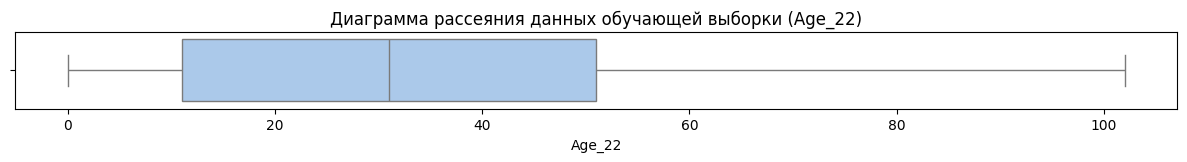

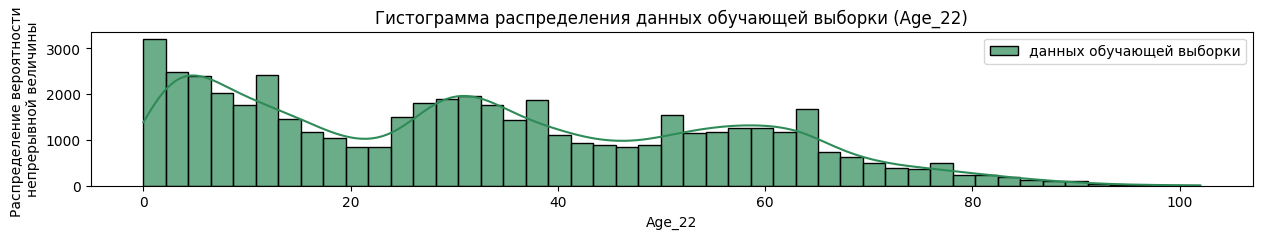

In [ ]:
feed_size(data_train1, 'Age_22', 'данных обучающей выборки')

In [ ]:
# напишем функцию проверки аномальных значений возраста у пациентов
def age(data, check_age1, name_data):
    print (f'{name_data}:')
    print(f'Количество пациентов старше {check_age1} лет по категориям')
    age_1 = data[data['Age_22'] >= check_age1]
    print(age_1['Relation'].value_counts())  #sort_values(by = 'Relation')
    print()
    print(f'Количество пациентов в 0 возрасте на 2022г по категориям')
    age_0 = data[data['Age_22'] == 0]
    print(age_0['Relation'].value_counts())  #sort_values(by = 'Relation')

In [ ]:
len(data_train1[(data_train1['Relation'] == 'Self') & (data_train1['Age_22'] >= 80)])

926

In [ ]:
age(data_train1, 80, 'Обучающая выборка')

Обучающая выборка:
Количество пациентов старше 80 лет по категориям
Relation
Self      926
Parent      9
Other       1
Spouse      1
Name: count, dtype: int64

Количество пациентов в 0 возрасте на 2022г по категориям
Relation
Child    963
Name: count, dtype: int64


In [ ]:
data_train1[(data_train1['Relation'] == 'Spouse') & (data_train1['Age_22'] >= 80)]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age_22
38460,1766875,Network-2,Saudi,Female,Spouse,unknown,0,365,0,0,365,3,80


In [ ]:
# Удаляем данные работников-пациентов старше 80 лет
data_train1 = data_train1[~((data_train1['Relation'] == 'Self') & (data_train1['Age_22'] >= 80))]
data_train1[data_train1['Age_22'] > 80]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age_22
25051,1458741,Network-1,Saudi,Female,Other,U86.2;N64.9;M25.50;I77.6;R10.3;M17;R22.9;N30;M...,0,365,9,30,365,6,83
48561,67035075,Network-1,Saudi,Female,Parent,H10;H25;R42,0,365,3,18,365,9,88
48569,67035604,Network-1,Saudi,Male,Parent,H02.1;R04.0;R00.2;E11;I48;H04;H10;I10;E11.42;H...,0,365,14,74,365,5,81
48610,67038160,Network-1,Saudi,Female,Parent,J45.9;E11;E66;E13.90;H93.1;J20;J45;M19.99;E11....,1,365,14,183,365,19,81
48620,67038699,Network-1,Saudi,Male,Parent,N18.9;G30;E78.5;E11.8;H04.3;N19;N40;D50;N39.0;...,1,365,22,200,365,24,92
48646,67039762,Network-1,Saudi,Male,Parent,unknown,0,365,0,0,365,0,82
48666,67041958,Network-1,Saudi,Female,Parent,J30;M54.5;K29.5;N30;R30.0;Z47;M47;Z01.0;K59.0;...,1,365,38,207,365,31,83
48678,67043491,Network-1,Saudi,Male,Parent,N41.0;R63.0;G31.3;R11;G21;M54.5;N40;F01;K11.7;...,1,365,28,139,365,16,84
49740,86697368,Network-1,Saudi,Male,Parent,unknown,0,365,0,0,365,2,84


#### Преобразуем проверочный датасет

In [ ]:
data_test = clean_data(data_holdout)
print('Предобработанный датасет:')
display(data_test.head())

'Проверим наличие пропусков в столбце DoB:'

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23


'Проверим наличие удалили ли данные о пациенте с посещениями в 22 году более 150 шт:'

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23


Предобработанный датасет:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age_22
0,1516424,Network-2,Saudi,Female,Child,A09,0,365,1,3,365,10
1,22210474,Network-1,Saudi,Female,Child,T78.4;R50.9;Z01.8;R05,0,365,4,22,365,27
2,1518945,Network-2,Saudi,Female,Spouse,D64.9;J06;H04.1;M13.9,0,365,5,11,365,60
3,1344077,Network-2,Saudi,Male,Child,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365,19
4,1354276,Network-2,Saudi,Female,Spouse,UNKRC;N64;A09,0,365,3,10,365,27


Статистические данные о распределении значений данных проверочной выборки (Age_22):


count   10000.000
mean       32.446
std        22.725
min         0.000
25%        11.000
50%        31.000
75%        52.000
max       100.000
Name: Age_22, dtype: float64

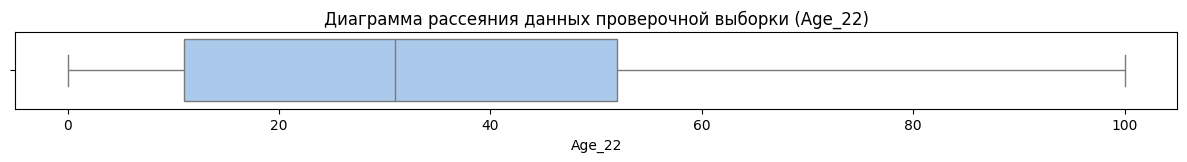

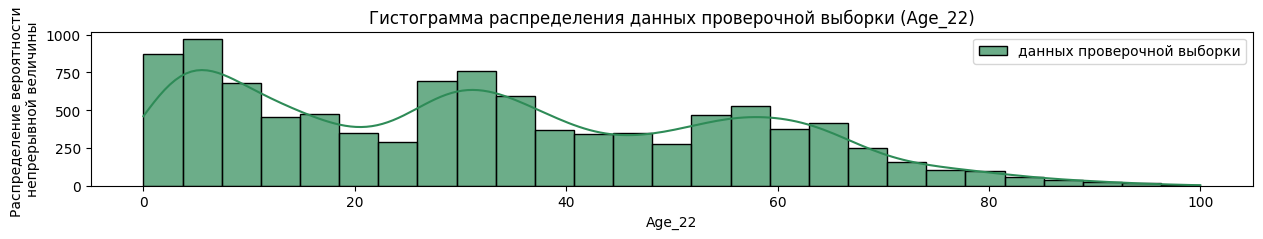

In [ ]:
feed_size(data_test, 'Age_22', 'данных проверочной выборки')

In [ ]:
len(data_test[(data_test['Relation'] == 'Self') & (data_test['Age_22'] >= 80)])

187

In [ ]:
age(data_test, 80, 'Тестовая выборка')

Тестовая выборка:
Количество пациентов старше 80 лет по категориям
Relation
Self      187
Child       1
Parent      1
Name: count, dtype: int64

Количество пациентов в 0 возрасте на 2022г по категориям
Relation
Child    183
Name: count, dtype: int64


In [ ]:
data_test[(data_test['Relation'] == 'Child') & (data_test['Age_22'] >= 60)]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age_22
809,1532655,Network-2,Saudi,Male,Child,R10;E55;R53;E11,0,365,4,8,161,83


In [ ]:
data_test_holduot = data_test.copy() # сохраним исходник
# Удаляем данные работников-пациентов старше 80 лет
data_test = data_test[~((data_test['Relation'] == 'Self') & (data_test['Age_22'] >= 80))]
data_test = data_test[~((data_test['Relation'] == 'Child') & (data_test['Age_22'] >= 60))]
data_test[data_test['Age_22'] > 80]

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age_22
9791,67052427,Network-1,Saudi,Male,Parent,Z49.0;H10;H04.1;N18.90;S09.9;H36.0;E11;N18;J20...,1,365,31,157,365,82


#### **Вывод:**
- Анализ новой фичи - возраст, показал:
- На обучающей выбрке:
  - видим странные значения относительно возраста - больше 100 лет и нулевой возраст
  - при приверке - 0 возраст - это дети, значит все ок с данными - это вполневероятные значения;
  - большое количество значений возраста работников страше 80 - 926 (считаю, что это уже отклонение, так как пенсионный возраст приблизительно 75 лет, допустим +5 лет еще работает, но больще - это явное отклонение) - удалим эти значения. Возраст родителей и супругов старше 80 - это уже реальные значения.
- На проверочной выбрке:
  - здесь также странные значения возраста работников - удаляем
  - также странное значение ребенка 83 года - тоже удаляем,
  

## **4. Подготовка общего датасета для дальнейшего исследования и обучения.**

6. Проверка модели на тестовой выборке.
7. Выводы.

Размер данных:      (49072, 13)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
Insured_PIN             0.000
Insured_Network         0.000
Nationality             0.000
Gender                  0.000
Relation                0.000
Diagnoses               0.000
HasChronicDisease       0.000
Exposition_22           0.000
number_of_visits_22     0.000
number_of_services_22   0.000
Exposition_23           0.000
number_of_visits_23     0.000
Age_22                  0.000
dtype: float64

Проверка структуры данных обучающей выборки:


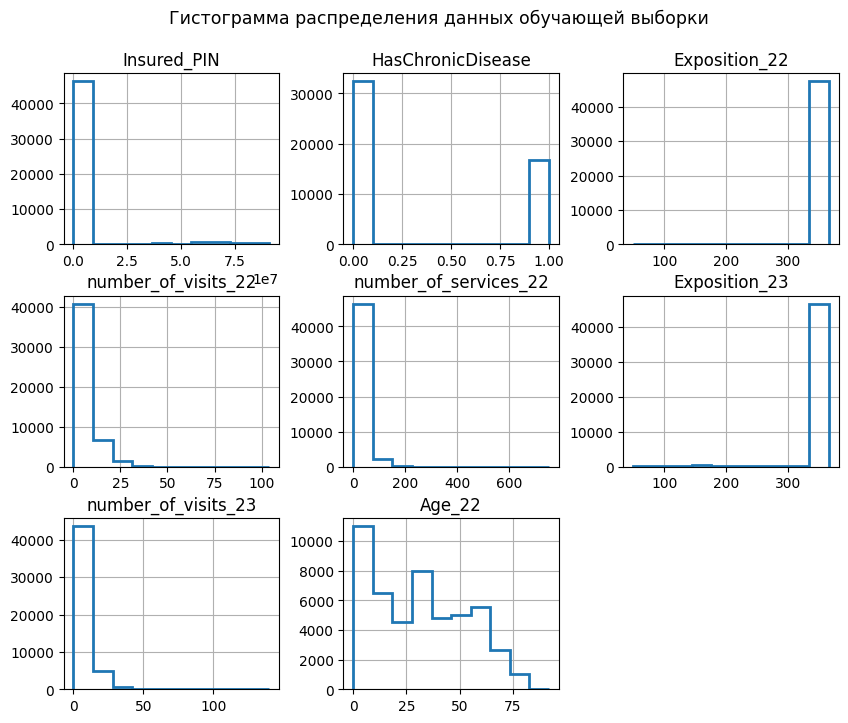

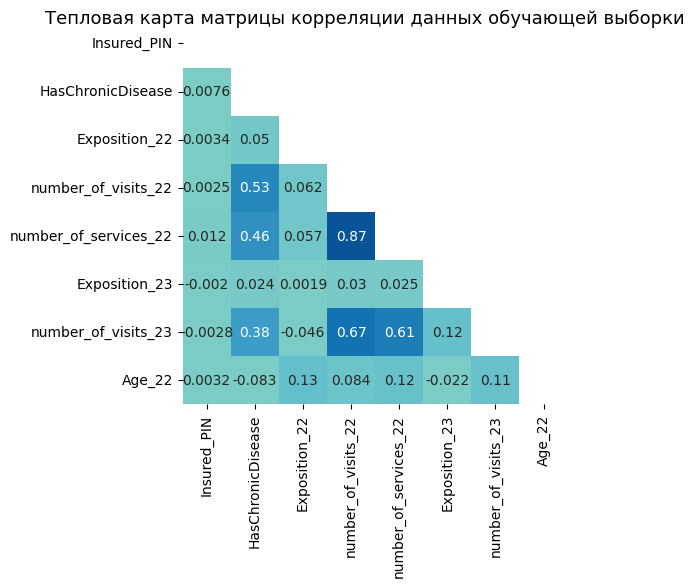

,Insured_PIN,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age_22
count,49072.000,49072.000,49072.000,49072.000,49072.000,49072.000,49072.000,49072.000
mean,5173110.879,0.340,358.799,5.766,22.533,355.721,5.926,31.399
std,14567090.458,0.474,35.846,6.557,29.335,43.514,6.794,21.767
min,7491.000,0.000,50.000,0.000,0.000,50.000,0.000,0.000
25%,1393880.750,0.000,365.000,1.000,3.000,365.000,1.000,11.000
50%,1456657.000,0.000,365.000,4.000,13.000,365.000,4.000,30.000
75%,1622732.250,1.000,365.000,8.000,31.000,365.000,8.000,50.000
max,91005334.000,1.000,365.000,104.000,754.000,365.000,140.000,92.000


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23,Age_22
0,1006786,Network-4,Group 2,Male,Self,unknown,0,365,0,0,365,0,48
1,1008861,Network-2,Saudi,Female,Child,J20.9;J02,0,365,1,2,365,4,5
2,1019055,Network-5,Group 2,Male,Self,J03.9,0,365,1,4,365,5,43
3,1019438,Network-1,Saudi,Male,Self,E56.9;J02;J00,1,365,3,18,365,11,37
4,1027311,Network-3,Group 3,Male,Self,unknown,0,365,0,0,365,0,61


In [ ]:
research(data_train1, 'данных обучающей выборки', figsize1=(10, 8), figsize2=(8, 5), silent=False)

Размер данных:      (9812, 12)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
Insured_PIN             0.000
Insured_Network         0.000
Nationality             0.000
Gender                  0.000
Relation                0.000
Diagnoses               0.000
HasChronicDisease       0.000
Exposition_22           0.000
number_of_visits_22     0.000
number_of_services_22   0.000
Exposition_23           0.000
Age_22                  0.000
dtype: float64

Проверка структуры данных обучающей выборки:


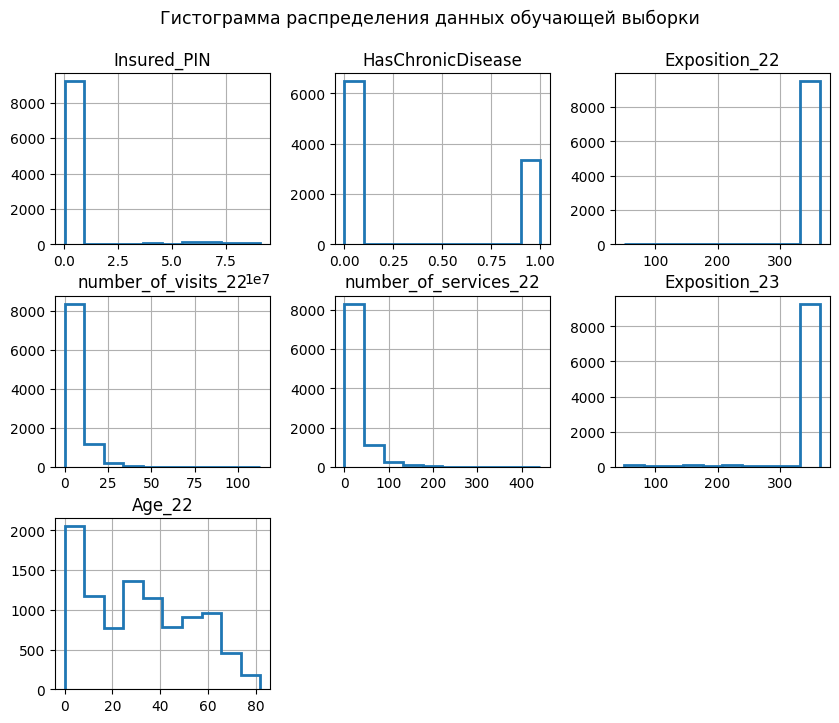

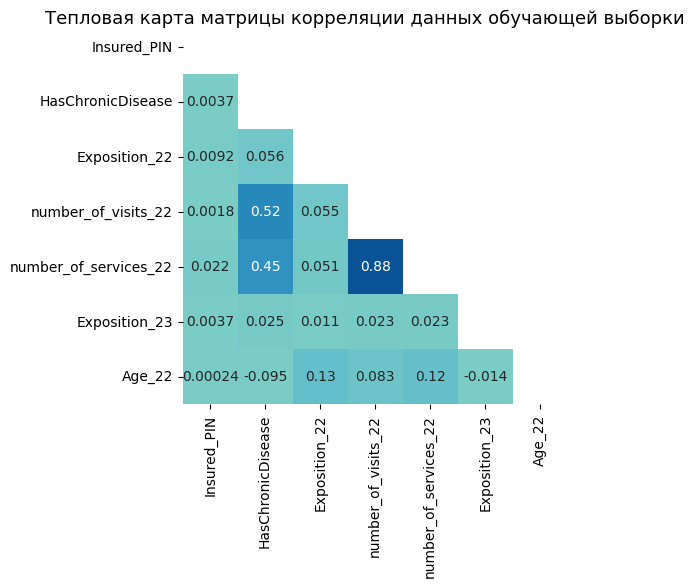

,Insured_PIN,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age_22
count,9812.000,9812.000,9812.000,9812.000,9812.000,9812.000,9812.000
mean,5394540.095,0.341,359.344,5.836,23.003,355.048,31.431
std,15011863.930,0.474,33.986,6.717,30.295,45.368,21.705
min,63665.000,0.000,50.000,0.000,0.000,50.000,0.000
25%,1394553.250,0.000,365.000,1.000,3.000,365.000,11.000
50%,1457414.500,0.000,365.000,4.000,13.000,365.000,30.000
75%,1632611.500,1.000,365.000,8.000,31.000,365.000,50.000
max,91051569.000,1.000,365.000,113.000,442.000,365.000,82.000


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,Age_22
0,1516424,Network-2,Saudi,Female,Child,A09,0,365,1,3,365,10
1,22210474,Network-1,Saudi,Female,Child,T78.4;R50.9;Z01.8;R05,0,365,4,22,365,27
2,1518945,Network-2,Saudi,Female,Spouse,D64.9;J06;H04.1;M13.9,0,365,5,11,365,60
3,1344077,Network-2,Saudi,Male,Child,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365,19
4,1354276,Network-2,Saudi,Female,Spouse,UNKRC;N64;A09,0,365,3,10,365,27


In [ ]:
research(data_test, 'данных обучающей выборки', figsize1=(10, 8), figsize2=(8, 5), silent=False)

In [ ]:
data_train1 = data_train1.drop(['number_of_services_22', 'Diagnoses'], axis=1)
data_test1 = data_test.drop(['number_of_services_22', 'Diagnoses'], axis=1)
# датасет не обрезанный по возрасту пациентов
data_test_holduot = data_test_holduot.drop(['number_of_services_22', 'Diagnoses'], axis=1)

#### Переведем категориальные типы данных в category, для более удобных расчетов в посроении моделей

In [ ]:
#переведем категориальные данные в category типы данных, для более удобных расчетов в посроении моделей
cat = ['Insured_Network', 'Nationality', 'Gender', 'Relation', 'HasChronicDisease'] #'Diagnoses',
data_train1[cat] = data_train1[cat].apply(pd.Categorical)
data_test1[cat] = data_test1[cat].apply(pd.Categorical)

# датасет не обрезанный по возрасту пациентов
data_test_holduot[cat] = data_test_holduot[cat].apply(pd.Categorical)

In [ ]:
# Установим столбец Insured_PIN в качестве индекса
data_train1.set_index('Insured_PIN', inplace=True)
data_test1.set_index('Insured_PIN', inplace=True)

# датасет не обрезанный по возрасту пациентов
data_test_holduot.set_index('Insured_PIN', inplace=True)

In [ ]:
express_info(data_train1, 'обучающей выборке')
express_info(data_test1, 'проверочной выборке')

# датасет не обрезанный по возрасту пациентов
#express_info(data_test_holduot, 'проверочной выборке не обрезанной по возрасту пациентов')

Информация о обучающей выборке:
<class 'pandas.core.frame.DataFrame'>
Index: 49072 entries, 1006786 to 9952098
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Insured_Network      49072 non-null  category
 1   Nationality          49072 non-null  category
 2   Gender               49072 non-null  category
 3   Relation             49072 non-null  category
 4   HasChronicDisease    49072 non-null  category
 5   Exposition_22        49072 non-null  int64   
 6   number_of_visits_22  49072 non-null  int64   
 7   Exposition_23        49072 non-null  int64   
 8   number_of_visits_23  49072 non-null  int64   
 9   Age_22               49072 non-null  int64   
dtypes: category(5), int64(5)
memory usage: 2.5 MB


,Insured_Network,Nationality,Gender,Relation,HasChronicDisease,Exposition_22,number_of_visits_22,Exposition_23,number_of_visits_23,Age_22
Insured_PIN,,,,,,,,,,
1006786,Network-4,Group 2,Male,Self,0,365,0,365,0,48
1008861,Network-2,Saudi,Female,Child,0,365,1,365,4,5
1019055,Network-5,Group 2,Male,Self,0,365,1,365,5,43
1019438,Network-1,Saudi,Male,Self,1,365,3,365,11,37
1027311,Network-3,Group 3,Male,Self,0,365,0,365,0,61



Информация о проверочной выборке:
<class 'pandas.core.frame.DataFrame'>
Index: 9812 entries, 1516424 to 1384402
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Insured_Network      9812 non-null   category
 1   Nationality          9812 non-null   category
 2   Gender               9812 non-null   category
 3   Relation             9812 non-null   category
 4   HasChronicDisease    9812 non-null   category
 5   Exposition_22        9812 non-null   int64   
 6   number_of_visits_22  9812 non-null   int64   
 7   Exposition_23        9812 non-null   int64   
 8   Age_22               9812 non-null   int64   
dtypes: category(5), int64(4)
memory usage: 432.2 KB


,Insured_Network,Nationality,Gender,Relation,HasChronicDisease,Exposition_22,number_of_visits_22,Exposition_23,Age_22
Insured_PIN,,,,,,,,,
1516424,Network-2,Saudi,Female,Child,0,365,1,365,10
22210474,Network-1,Saudi,Female,Child,0,365,4,365,27
1518945,Network-2,Saudi,Female,Spouse,0,365,5,365,60
1344077,Network-2,Saudi,Male,Child,1,365,9,365,19
1354276,Network-2,Saudi,Female,Spouse,0,365,3,365,27


#### Разделение общего датасета на выборки для обучения и проверки модели.

In [ ]:
#входящие данные
RANDOM_STATE = 12345
cv_counts = 5
features = data_train1.drop('number_of_visits_23', axis=1)
target = data_train1['number_of_visits_23']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, target,
                                                            test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
#Проверим размеры выборок:
for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)

(36804, 9)
(36804,)
(12268, 9)
(12268,)


### Кодирование и масштабирование признаков - стандартизация данных, по необходимости.
Так как у нас присутствуют категориальные признаки, применим методы OE и OHE для кодирования.

Так как у нас разные модели, то используем разные методы кодирования. Для линейной модели используем метод прямого кодирования ОНЕ

In [ ]:
#категориальные признаки
cat_features = features_train.select_dtypes(include='category').columns.to_list()
print(cat_features)
#численные признаки
num_features = features_train.select_dtypes(exclude='category').columns.to_list()
num_features

['Insured_Network', 'Nationality', 'Gender', 'Relation', 'HasChronicDisease']


['Exposition_22', 'number_of_visits_22', 'Exposition_23', 'Age_22']

In [ ]:
#для нелинейных моделей, в частности GBMRegressor
#Преобразуем категориальные признаки в численные с помощью техники порядкового кодирования OE
encoder = OrdinalEncoder( dtype=np.int16)
features_train_oe = features_train[cat_features]
encoder.fit(features_train[cat_features])
features_train_oe[cat_features] = encoder.transform(features_train[cat_features]).astype(np.int16)

features_test_oe = features_test[cat_features]
encoder.fit(features_test[cat_features])
print('Закодированные методом OE данные')
display(features_train_oe.head(3))
display(features_test_oe.head(3))

Закодированные методом OE данные


,Insured_Network,Nationality,Gender,Relation,HasChronicDisease
Insured_PIN,,,,,
63067825,1,2,1,3,1
2396214,1,5,1,0,1
1397858,1,5,0,4,1


,Insured_Network,Nationality,Gender,Relation,HasChronicDisease
Insured_PIN,,,,,
1532343,Network-2,Saudi,Female,Spouse,0
1408646,Network-2,Saudi,Female,Child,1
1475206,Network-2,Saudi,Female,Self,0


In [ ]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()
#запускаем энкодер и обучаем выборки
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_ohe[cat_features])
features_train_ohe[encoder_ohe.get_feature_names_out()] = \
                        encoder_ohe.transform(features_train_ohe[cat_features])
features_train_ohe = features_train.drop(cat_features, axis=1)

features_test_ohe[encoder_ohe.get_feature_names_out()] = \
                        encoder_ohe.transform(features_test_ohe[cat_features])
features_test_ohe = features_test.drop(cat_features, axis=1)
print('Закодированные методом OHE данные')
display(features_train_ohe.head(2))
display(features_test_ohe.head(2))

# стандартизируем данные ohe
features_train_ohe_sc = features_train_ohe.copy()
features_test_ohe_sc = features_test_ohe.copy()
scaler = StandardScaler()
features_train_ohe_sc[num_features] = scaler.fit_transform(features_train[num_features]) #train
features_test_ohe_sc[num_features] = scaler.transform(features_test_ohe_sc[num_features])#тестовую
print('Закодированные методом OHE стандартизированные данные')
display(features_train_ohe_sc.head(2))
display(features_test_ohe_sc.head(2))

Закодированные методом OHE данные


,Exposition_22,number_of_visits_22,Exposition_23,Age_22
Insured_PIN,,,,
63067825,306,2,365,54
2396214,365,6,365,3


,Exposition_22,number_of_visits_22,Exposition_23,Age_22
Insured_PIN,,,,
1532343,365,0,156,37
1408646,365,11,365,6


Закодированные методом OHE стандартизированные данные


,Exposition_22,number_of_visits_22,Exposition_23,Age_22
Insured_PIN,,,,
63067825,-1.467,-0.574,0.213,1.038
2396214,0.173,0.037,0.213,-1.306


,Exposition_22,number_of_visits_22,Exposition_23,Age_22
Insured_PIN,,,,
1532343,0.173,-0.879,-4.590,0.257
1408646,0.173,0.801,0.213,-1.168


#### Выводы:
- Проверила обработанный датасет с новыми фичами на корреляцию, аномалии и дубликаты.
- все же считаю, что имеет смысл удалить один из столбцов с высокой корреляцией: `number_of_visits_22` и `number_of_services_22`.
Оставляю `number_of_visits_22`.
- думаю, в рамках построения данной модели можно удалить данные о диагнозах - эта информация могла бы быть более полезна для создания новых фичей, как, например, - количество диагнозов.
  (нет времени, к сожалению на это сейчас, но покрутить это было бы интересно)
>  Потенциально - можно еще поработать:
  -  со столбцом Insured_Network: присвоить просто цифровые категории. - Также на будущее - интересна информация из столбца с диагнозами, если расшифровать, то можно с токенами поработать, улучшить метрики, а также возможно это потенциал ля решения другой задачи (была идея списки создать, но в рамках этой задачи, думаю нет смысла).
- поготовила данные для обучения

## **5. Обучение модели.**

#### **Описание моделей:**
У нас задача регресии, начит будем рассматривать линейные и нелинейные модели регреcсии.

- **Линейные модели:** **Линейная регрессия**
- **Случайный лес**

- **Нелинейные модели**, работающие по алгоритму градиентного бустинга:
  - **CatBoostRegressor**,
  - **XGBRegressor**
  - **LGBMRegressor**

Будем использовать **pipeline** вместе с кросс-валидацией ( методами `GridSearchCV `и `RandomSearchCV`). Это позволит кодировать и масштабировать отдельно каждую тренировочную и валидационную выборки внутри кросс-валидации (без «подглядывания»).

### **Кросс-валидация**

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))
models.append(('CatBoostR', CatBoostRegressor(random_state = RANDOM_STATE, verbose=False)))
models.append(('LGBMR', LGBMRegressor(random_state = RANDOM_STATE, verbose=-1)))
models.append(('XGBR', XGBRegressor(random_state = RANDOM_STATE)))

def cvs (models, features_train, target_train):

    # запускаем расчет моделей в цикле
    results = []
    names = []
    for name, model in models:
        cv_mae = (cross_val_score(model,features_train,
                                 target_train, cv=5,
                                 scoring='neg_mean_absolute_error').mean() * -1)
        results.append(cv_mae)
        names.append(name)
        print('MAE %s:  %f ' % (name, cv_mae.mean()))#(%f), cv_mae.std()
        #print('RMSE %s:  %f ' % (name, abs(cv_mae.mean())** 0.5))

    return results, names


In [ ]:
%%time
#Закодированные методом ОНЕ и стандартизированные
results_ohe_sc, names_ohe_sc = cvs (models, features_train_ohe_sc, target_train)
#print(results_ohe)

MAE LR:  3.286802 
RMSE LR:  1.812954 
MAE RF:  3.364445 
RMSE RF:  1.834242 
MAE CatBoostR:  3.194805 
RMSE CatBoostR:  1.787402 
MAE LGBMR:  3.201535 
RMSE LGBMR:  1.789283 
MAE XGBR:  3.246406 
RMSE XGBR:  1.801779 
CPU times: user 58.9 s, sys: 2.36 s, total: 1min 1s
Wall time: 42.3 s


In [ ]:
%%time
#Закодированные методом ОНЕ
results_ohe, names_ohe = cvs (models, features_train_ohe, target_train)

MAE LR:  3.286802 
RMSE LR:  1.812954 
MAE RF:  3.365912 
RMSE RF:  1.834642 
MAE CatBoostR:  3.194842 
RMSE CatBoostR:  1.787412 
MAE LGBMR:  3.201538 
RMSE LGBMR:  1.789284 
MAE XGBR:  3.246406 
RMSE XGBR:  1.801779 
CPU times: user 58.8 s, sys: 3.29 s, total: 1min 2s
Wall time: 48.5 s


In [ ]:
%%time
#Закодированные методом ОЕ
results_oe, names_oe = cvs (models, features_train_oe, target_train)

MAE LR:  4.117769 
RMSE LR:  2.029229 
MAE RF:  4.062904 
RMSE RF:  2.015665 
MAE CatBoostR:  4.060154 
RMSE CatBoostR:  2.014982 
MAE LGBMR:  4.055566 
RMSE LGBMR:  2.013844 
MAE XGBR:  4.063881 
RMSE XGBR:  2.015907 
CPU times: user 44.6 s, sys: 2.44 s, total: 47 s
Wall time: 30 s


In [ ]:
results_cv = pd.DataFrame(results_ohe, index = names_ohe, columns = ['mae_cv'] )
results_cv

,mae_cv
LR,3.287
RF,3.366
CatBoostR,3.195
LGBMR,3.202
XGBR,3.246


#### **Вывод:**

- Проверка кросс-валидации показала, что лучше всего показал метод кодировки данных OHE. Стандартизированные данные показали незначительно лучший результат. не будем их использовать. Данные, закодированные методом OE хуже работают на всех моделях.
- Лучше всего себя показали бустинговые модели:
> **CatBoostR**:
   - **MAE CatBoostR**:  3.194805
   - **RMSE CatBoostR**:  1.787402

 > **CatBoostR**:
   - **MAE LGBMR**:  3.201538
   - **RMSE LGBMR**:  1.789284
Все же лучший результат дают данные, закодированные OHE - поэтому будем работать с ними.

Приступим непосредственно к обучению:

> уберем модели, котрые дали результат хуже, оставим 3 шт., чтобы не перегружать проект.
используем pipeline, перебор методами GridSearchCV и RandomSearchCV

#### **Проверка модели на адекватность с помощью константной модели**

In [ ]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train_ohe, target_train)
    predict = dummy.predict(features_test_ohe)
    mae_dummy = mean_absolute_error(target_test, predict)
    print(f'Итоговая оценка на константной модели : MAE_{strategy} = {mae_dummy}')

Итоговая оценка на константной модели : MAE_mean = 4.80621307004133
Итоговая оценка на константной модели : MAE_median = 4.521111835670036


Вывод:
 - видим, что константная модель Хуже, чем наши - значит, мы идем верным путем :)

### **Непосредственно обучение моделей**

In [ ]:
# Вводим переменные
model_3 = CatBoostRegressor(random_state = RANDOM_STATE, verbose=False)
model_4 = LGBMRegressor(random_state = RANDOM_STATE, verbose=-1)
model_5 = XGBRegressor(random_state = RANDOM_STATE)

In [ ]:
%%time
# Инициируем гиперпараметры для рассматриваемых моделях
param3 = {}
param3['regression__learning_rate'] = [i/10 for i in range(1, 6)]
param3['regression__n_estimators'] = [50, 100, 10]
param3['regression__loss_function'] = ['MAE']
param3['regression__max_depth'] = [i for i in range(5,10)]
#param3['regression__class_weight'] = [None, 'balanced']
param3['regression'] = [model_3]

param4 = {}
param4['regression__learning_rate'] = [i/10 for i in range(1, 6)]
param4['regression__n_estimators'] = [10, 50, 100, 250]
param4['regression__max_depth'] = [i for i in range(5,15)]
param4['regression__boosting_type'] = ['gbdt']
param4['regression'] = [model_4]

param5 = {}
param5['regression__learning_rate'] = [i/100 for i in range(1, 50)]
param5['regression__silent'] = [True]
param5['regression'] = [model_5]

CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 30.8 µs


In [ ]:
%%time
pipeline = Pipeline([('regression', model_3)])
params = [param3, param4, param5] #param1, param2,

CPU times: user 22 µs, sys: 2 µs, total: 24 µs
Wall time: 28.6 µs


#### **GridSearchCV**

In [ ]:
%%time
start = time.time()
gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').fit(features_train_ohe, target_train)
end = time.time()
t_gs=round(end-start,2)

CPU times: user 17.7 s, sys: 3 s, total: 20.7 s
Wall time: 9min 29s


In [ ]:
# Гиперпараметры лучшей модели на GridSearchCV
gs.best_params_

{'regression': <catboost.core.CatBoostRegressor at 0x7854dfa95180>,
 'regression__learning_rate': 0.1,
 'regression__loss_function': 'MAE',
 'regression__max_depth': 9,
 'regression__n_estimators': 100}

In [ ]:
# MAE для лучшей модели
mae_gs = gs.best_score_
print(f'Абсолютное среднее отклонение лучшей модели, найденной методом GridSCV MAE_train = {round(mae_gs.mean() * -1, 2)}')

Абсолютное среднее отклонение лучшей модели, найденной методом GridSCV MAE_train = 3.08


#### **RandomizedSearchCV**

In [ ]:
%%time
start = time.time()
rs = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').fit(features_train_ohe, target_train)
end = time.time()
t_rs=round(end-start,2)

CPU times: user 1.59 s, sys: 123 ms, total: 1.71 s
Wall time: 14 s


In [ ]:
# Гиперпараметры лучшей модели на RandomizedSearchCV
rs.best_params_

{'regression__n_estimators': 100,
 'regression__max_depth': 6,
 'regression__loss_function': 'MAE',
 'regression__learning_rate': 0.4,
 'regression': <catboost.core.CatBoostRegressor at 0x7854dfa95180>}

In [ ]:
# MAE для лучшей модели
mae_rs = rs.best_score_
print(f'Абсолютное среднее отклонение лучшей модели, найденной методом RandomSCV MAE_train = {round(mae_rs.mean() * -1, 2)}')

Абсолютное среднее отклонение лучшей модели, найденной методом RandomSCV MAE_train = 3.09


## **6. Тестирование модели.**
Исследование значимости признаков лучшей модели.

In [ ]:
# Проверяю лучшую модель, найденную через **GridSearchCV** на тестовой выборке
mae_test_gs = mean_absolute_error(gs.predict(features_test_ohe), target_test)
print(f'Абсолютное среднее отклонение лучшей модели, найденной методом GridSearchCV MAE_test = {round(mae_test_gs,2)}')

Абсолютное среднее отклонение лучшей модели, найденной методом GridSearchCV MAE_test = 3.12


In [ ]:
index = names_ohe
data = {'mae_cv': results_ohe,
        'mae_GrinSCV':['None', 'None', round(mae_gs.mean() * -1, 2), 'None','None'],
        'mae_RandomSCV':['None', 'None', round(mae_rs.mean() * -1, 2), 'None','None'],
        'mae_test_GrinSCV':['None', 'None', round(mae_test_gs,2), 'None','None'],
        'mae_test_RandomSCV':['None', 'None', round(mae_test_gs, 2), 'None','None']}

results_cv = pd.DataFrame(data=data, index=index)
#results_cv['Выполнение задачи'] = results_cv['mae_test_RandomSCV'] <= 6.8
results_cv

,mae_cv,mae_GrinSCV,mae_RandomSCV,mae_test_GrinSCV,mae_test_RandomSCV
LR,3.287,None,None,None,None
RF,3.366,None,None,None,None
CatBoostR,3.195,3.080,3.090,3.120,3.120
LGBMR,3.202,None,None,None,None
XGBR,3.246,None,None,None,None


### **Исследование значимости признаков лучшей модели**

In [ ]:
%%time
#найдем признаки лучшей модели полученной методом GridSCV
start = time.time()
#gs_importances = gs.fit(features_train_scale, target_train)
feature_importances_gs = gs.best_estimator_._final_estimator.feature_importances_
feature_importances_gs
end = time.time()
t_rs=round(end-start,2)

CPU times: user 394 µs, sys: 0 ns, total: 394 µs
Wall time: 402 µs


In [ ]:
# визуализируем важность признаков
def graph_features (model, features, name):
    feature_importance = pd.DataFrame((model), list(features.columns),columns=['Значения'])\
                                        .reset_index().rename(columns={'index':'Признаки'})
    plt.figure(figsize=(10, 4))
    sns.barplot(x="Значения", y="Признаки", data=feature_importance.sort_values(by="Значения", ascending=False), palette = 'tab20')#'Pastel2','rainbow'
    plt.title(f'Оценка важности признаков {name}')
    plt.tight_layout()
    plt.show()

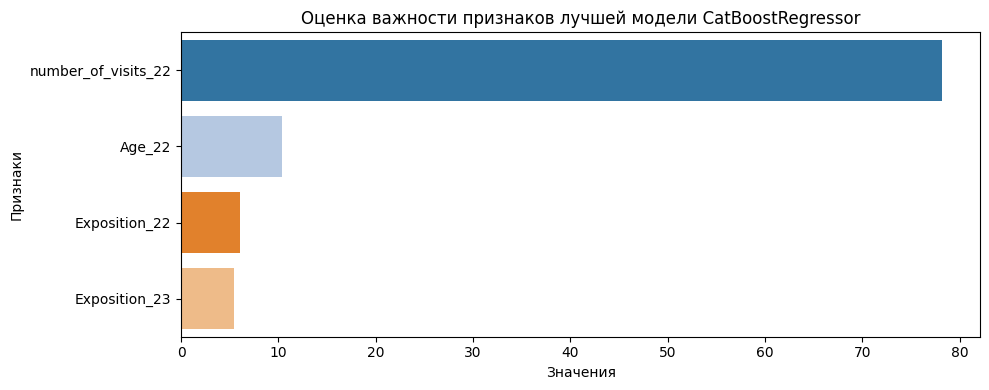

In [ ]:
graph_features (feature_importances_gs, features_test_ohe, 'лучшей модели CatBoostRegressor')

### **Вывод:**
- Провела перекрестную проверку моделей:
  - лучшей себя показала **CatBoostRegressor: MAE = 3.195**.

- Проверка модели на адекватность с помощью константной модели показала, что наша модель прошла проверку на вменяемость.
Значения `MAE`, показанные **DummyRegressor**, оказались значительно выше, чем у **CatBoostRegressor**.

- Провела обучение и подбор параметров 3 моделей:
 - Модель **LightGBMRegressor**
 - Модель **CatBoostRegressor**
 - Модель **LGBMRegressor**
- Использовала методы: **RandomizedSearchCV** и **GridSearchCV**
в итоге получила лучшую модель опять же **CatBoostRegressor** обоими методами с практически идентичными параметрами:
  - 'n_estimators': 100,
  - 'max_depth': 9,
  - 'loss_function': 'MAE',
  - 'learning_rate': 0.1

- Абсолютное среднее отклонение лучшей модели **CatBoostRegressor**, найденной методом **GridSCV: MAE_train = 3.08** с минимальной разницей от модели найденной методом **RandomizedSearchCV**.

- на тестовой выборке лучший результат показала модель CatBoostRegressor, полученная методом GridSearchCV:
   -  **MAE_test = 3.12**

и я бы в принципе при таких результатах выбрала бы именно метод **RandomizedSearchCV**, так как поиск модели занимает значительно меньше времени t = 9.02 сек, в отличие от **GridSearchCV** t = 9 минут.

Тем не менее останавливаемся на модели, как лучшей,

   > **CatBoostRegressor**: `loss_function': 'MAE', max_depth': 9, n_estimators': 100, 'learning_rate': 0.1`, полученной методом **GridSearchCV**
   - **MAE_test = 3.12**

- при анализе важности признаков выявилось, что наиболее важными признаками является `number_of_visits_22`. А значит, модель работает правильно, так как именно этот признак должен быть наиболее важным.
 > общий список важных признаков:
   - `number_of_visits_22`
   - `Age_22`
   - `Exposition_22`
   - `Exposition_23`

## **7. Предскажем данные на выборке holdout.**
Создаем файл .csv с предсказаниями на выборке holdout с указанием ид застрахованного и предсказанием модели

In [ ]:
data_test1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9812 entries, 1516424 to 1384402
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Insured_Network      9812 non-null   int8    
 1   Nationality          9812 non-null   category
 2   Gender               9812 non-null   category
 3   Relation             9812 non-null   category
 4   HasChronicDisease    9812 non-null   category
 5   Exposition_22        9812 non-null   int64   
 6   number_of_visits_22  9812 non-null   int64   
 7   Exposition_23        9812 non-null   int64   
 8   Age_22               9812 non-null   int64   
dtypes: category(4), int64(4), int8(1)
memory usage: 431.9 KB


In [ ]:
cat = ['Insured_Network', 'Nationality', 'Gender', 'Relation', 'HasChronicDisease'] #'Diagnoses',
for col in cat:
    data_test1[col] = data_test1[col].astype('category').cat.codes

# Предскажем число визитов для датасета data_holdout
predictions = gs.predict(data_test1)

# Печать предсказаний
print(predictions)

[ 1.7404945   4.16473477  5.36287251 ...  2.24902023  1.80732455
 22.42748116]


In [ ]:
# Создаем предсказания модели
predictions_holdout = pd.DataFrame({'Insured_PIN': data_test1.index, 'prediction': predictions})
# Сохраняем DataFrame в файл CSV
predictions_holdout.to_csv('predictions_holdout.csv', index=False)
predictions_holdout

,Insured_PIN,prediction
0,1516424,1.740
1,22210474,4.165
2,1518945,5.363
3,1344077,6.704
4,1354276,3.776
...,...,...
9807,3948786,8.088
9808,67038285,9.048
9809,1371592,2.249
9810,62818434,1.807


In [ ]:
# Это - если нужен полный файл
#data_holdout1 = data_test1.assign(prediction=predictions)
#data_holdout1 = data_holdout1.reset_index()
#data_holdout1.head()

**ВАЖНЫЙ КОММЕНТАРИЙ!!!**

Основное предсказание сделала на выборке, где удалила всех работников старше 80 лет!!!

также удалила ребенка 80-летнего (очень странные данные)

Предсказание на исходных данных этого датасета -

НИЖЕ выборка

In [ ]:
# !!! если проверяем только по всему - не обрезанному датасету
for col in cat:
    data_test_holduot[col] = data_test_holduot[col].astype('category').cat.codes

# Предскажем число визитов для датасета data_holdout
predictions_full = gs.predict(data_test_holduot)

# Печать предсказаний
print(predictions_full)

[ 1.7404945   4.16473477  5.36287251 ...  2.24902023  1.80732455
 22.42748116]


In [ ]:
# Создаем предсказания модели
predictions_full_holdout = pd.DataFrame({'Insured_PIN': data_test_holduot.index, 'prediction': predictions_full})
# Сохраняем DataFrame в файл CSV
predictions_full_holdout.to_csv('predictions_full_holdout.csv', index=False)
predictions_full_holdout

,Insured_PIN,prediction
0,1516424,1.740
1,22210474,4.165
2,1518945,5.363
3,1344077,6.704
4,1354276,3.776
...,...,...
9995,3948786,8.088
9996,67038285,9.048
9997,1371592,2.249
9998,62818434,1.807
